# Experiment 02


The current approach for creating train, validation and test data sets is to split 
the data in long-format, i.e. one observation is an intensity value from one sample representing one peptide, into the desired splits. In this process missing values are not regarded.

- [x] mask entries in larger dataset in long-format
- [x] mask peptides based on their frequency in samples (probability of being observed)
- [x] create *long-format* training data set without masked values for each model
    - FNN based on embeddings of peptides and samples (long-format **without** missing values)
    - Denoising AE (wide-format **with** missing values)
    - VAE (wide-format **with** missing values)
- [ ] restrict to only a training data split of consective data: Increase number of samples.
    - focus on best reconstruction performance
    - mean comparison

### Collaborative Filtering model

- Cannot accomodate iid assumption of statistical test in current setup for embedding vectors.
  - if pretrained model should be applied to an new batch of replicates (with a certain condition) one would need to find a way to initialize the sample embeddings without fine-tuning the model

In [1]:
import logging
from pprint import pprint
import seaborn
import numpy.testing as npt  # fastcore.test functionality

from pathlib import Path


import vaep.io_images
from vaep.pandas import interpolate
from vaep.model import build_df_from_pred_batches

from src.nb_imports import *
from src import metadata
from src.logging import setup_logger

logger = setup_logger(logger=logging.getLogger('vaep'))
logger.info("Experiment 02")

figures = {}  # collection of ax or figures

FOLDER_MQ_TXT_DATA = data\mq_out
vaep - INFO     Experiment 02


In [2]:
# None takes all
N_SAMPLES: int = 1000
n_features: int = 50
ADD_TENSORBOARD: bool = False
FN_PEPTIDE_INTENSITIES: Path = (
    config.FOLDER_DATA / 'df_intensities_N07285_M01000')  # 90%
epochs_max = 10
batch_size = 32
latent_dim = 2
most_common: bool = False
most_uncommon: bool = False
out_folder: str = 'poster'
# write to read only config ? namedtuple?

In [3]:
# Parameters
n_feat = 50
n_epochs = 10
out_folder = "runs/2D"


In [4]:
BATCH_SIZE, EPOCHS = batch_size, epochs_max
folder = Path(out_folder) / f'feat_{n_features:04d}_epochs_{epochs_max:03d}'
print(f"{folder = }")

if most_common and most_uncommon:
    raise ValueError(f"Cannot be both True: {most_common = } and {most_uncommon = }")

folder = Path('runs/2D/feat_0050_epochs_010')


## Raw data

In [5]:
FN_PEPTIDE_INTENSITIES = Path(FN_PEPTIDE_INTENSITIES)

In [6]:
analysis = AnalyzePeptides(fname=FN_PEPTIDE_INTENSITIES, nrows=None)
analysis.df.columns.name = 'peptide'
analysis.log_transform(np.log2)
analysis

AnalyzePeptides with attributes: M, N, df, index_col, is_log_transformed, is_wide_format, log_fct, stats

In [7]:
# some date are not possible in the indices
rename_indices_w_wrong_dates = {'20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_03': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_03',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_12': '20180330_QE10_nLC0_MR_QC_MNT_Hela_12',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_01': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_01',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_11': '20180330_QE10_nLC0_MR_QC_MNT_Hela_11',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_02': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_02'}
analysis.df.rename(index=rename_indices_w_wrong_dates, inplace=True)

### Select N consecutive samples

In [8]:
analysis.get_consecutive_dates(n_samples=N_SAMPLES)

Get 1000 samples.
Training data referenced unter: df_1000
Updated attribute: df


peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,31.517,32.278,30.832,31.541,32.803,33.676,31.927,31.906,27.631,33.747,...,31.452,28.512,29.634,31.134,30.690,30.142,29.881,31.508,29.884,29.468
20190805_QE1_nLC2_AB_MNT_HELA_01,31.104,31.747,28.999,28.458,30.588,28.800,32.415,31.270,30.077,32.357,...,29.504,29.435,28.424,29.489,29.702,29.877,28.777,30.471,27.793,29.185
20190805_QE1_nLC2_AB_MNT_HELA_02,31.248,31.923,28.643,28.257,31.068,28.864,32.340,31.672,31.636,32.466,...,29.728,29.741,28.667,29.647,29.555,29.709,28.592,30.776,27.955,29.272


In [9]:
assert not analysis.df._is_view

## Long format

- Data in long format: (peptide, sample_id, intensity)
- no missing values kept
- 

In [10]:
analysis.df_long.head()

intensity
Sample ID                           peptide                       
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAAAAAALQAK             29.591
                                    AAFDDAIAELDTLSEESYK     31.264
                                    AAHSEGNTTAGLDMR         28.098
                                    AAVATFLQSVQVPEFTPK      28.694
                                    AAVEEGIVLGGGCALLR       30.208

In [11]:
assert analysis.df_long.isna().sum().sum(
) == 0, "There are still missing values in the long format."

In [12]:
analysis.df_wide.head()

peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216


In [13]:
assert analysis.df_wide.isna().sum().sum(
) > 0, "There are no missing values left in the wide format"

### Sampling peptides by their frequency (important for later)

- higher count, higher probability to be sampled into training data
- missing peptides are sampled both into training as well as into validation dataset
- everything not in training data is validation data

In [14]:
# freq_per_peptide = analysis.df.unstack().to_frame('intensity').reset_index(1, drop=True)
freq_per_peptide = analysis.df_long['intensity']
freq_per_peptide = freq_per_peptide.notna().groupby(level=1).sum()
print(f"{n_features = }")


n_features = 50


### Selecting N
 - most common
 - most uncommon

In [15]:
freq_per_pepitde = freq_per_peptide.sort_values(ascending=False)

if most_common:
    freq_per_pepitde = freq_per_pepitde.iloc[:n_features]
elif most_uncommon:
    freq_per_pepitde = freq_per_pepitde.iloc[-n_features:]
else:
    freq_per_pepitde = freq_per_pepitde.sample(n_features)
    
assert len(freq_per_pepitde.index) == n_features

freq_per_pepitde

peptide
DLEEDHACIPIK               998
TLTAVHDAILEDLVFPSEIVGK     960
EQISDIDDAVR                992
IGDLQAFQGHGAGNLAGLK      1,000
TVLMNPNIASVQTNEVGLK        999
MALIGLGVSHPVLK             999
TYFSCTSAHTSTGDGTAMITR      994
EMNDAAMFYTNR               990
EAAENSLVAYK                952
ASNGDAWVEAHGK              984
KTEAPAAPAAQETK             994
GANDFMCDEMER               975
FNADEFEDMVAEK              991
SLEDQVEMLR                 982
LGQSDPAPLQHQMDIYQK         999
AAVPSGASTGIYEALELRDNDK     954
IIAPPERK                   940
HLAGLGLTEAIDK              998
PLRLPLQDVYK                947
SEIDLFNIRK                 951
ILLTEPPMNPTK               971
TATPQQAQEVHEK              997
IYVDDGLISLQVK              995
FGYVDFESAEDLEK             989
SAYDSTMETMNYAQIR           991
DSYVGDEAQSK                999
NSSYFVEWIPNNVK             984
YNILGTNTIMDK               998
QAQIEVVPSASALIIK           983
AHSSMVGVNLPQK            1,000
LLLGAGAVAYGVR              977
LMDVGLIAIR                 996


In [16]:
analysis.df = analysis.df[freq_per_pepitde.index]
# ToDo: clean-up other attributes needs to be integrated
del analysis._df_long  # , analysis._df_wide
analysis.df_long

intensity
Sample ID                           peptide                          
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 DLEEDHACIPIK               29.764
                                    TLTAVHDAILEDLVFPSEIVGK     30.168
                                    EQISDIDDAVR                29.423
                                    IGDLQAFQGHGAGNLAGLK        29.867
                                    TVLMNPNIASVQTNEVGLK        28.762
...                                                               ...
20190805_QE1_nLC2_AB_MNT_HELA_04    HEQNIDCGGGYVK              30.912
                                    ESEPQAAAEPAEAK             30.445
                                    AIVAIENPADVSVISSR          29.348
                                    TVTAMDVVYALK               34.581
                                    NSNLVGAAHEELQQSR           29.348

[49254 rows x 1 columns]

- biological stock differences in PCA plot. Show differences in models. Only see biological variance

## PCA plot of raw data

vaep - ERROR    Could not find LC instrument in 20190418_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190422_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190425_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190501_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190506_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190514_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190520_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190521_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190524_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190526_QX4_LiSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190527_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190530_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190603_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190606_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190607_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190611_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190615_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX8_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190618125902


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190619010035


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_centroid


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng_190621161214


vaep - ERROR    Could not find LC instrument in 20190624_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190629_QX4_JiYu_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190701_QX4_MePh_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190703_QX4_MaTa_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng_190707003046


vaep - ERROR    Could not find LC instrument in 20190717_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190718_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190719_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX4_StEb_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX8_ChSc_MA_HeLa_500ng_190722174431


vaep - ERROR    Could not find LC instrument in 20190725_QX2_MePh_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190726_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190731_QX8_ChSc_MA_HeLa_500ng


Created metadata DataFrame attribute `df_meta`.
Added proportion of not NA values based on `df` intensities.


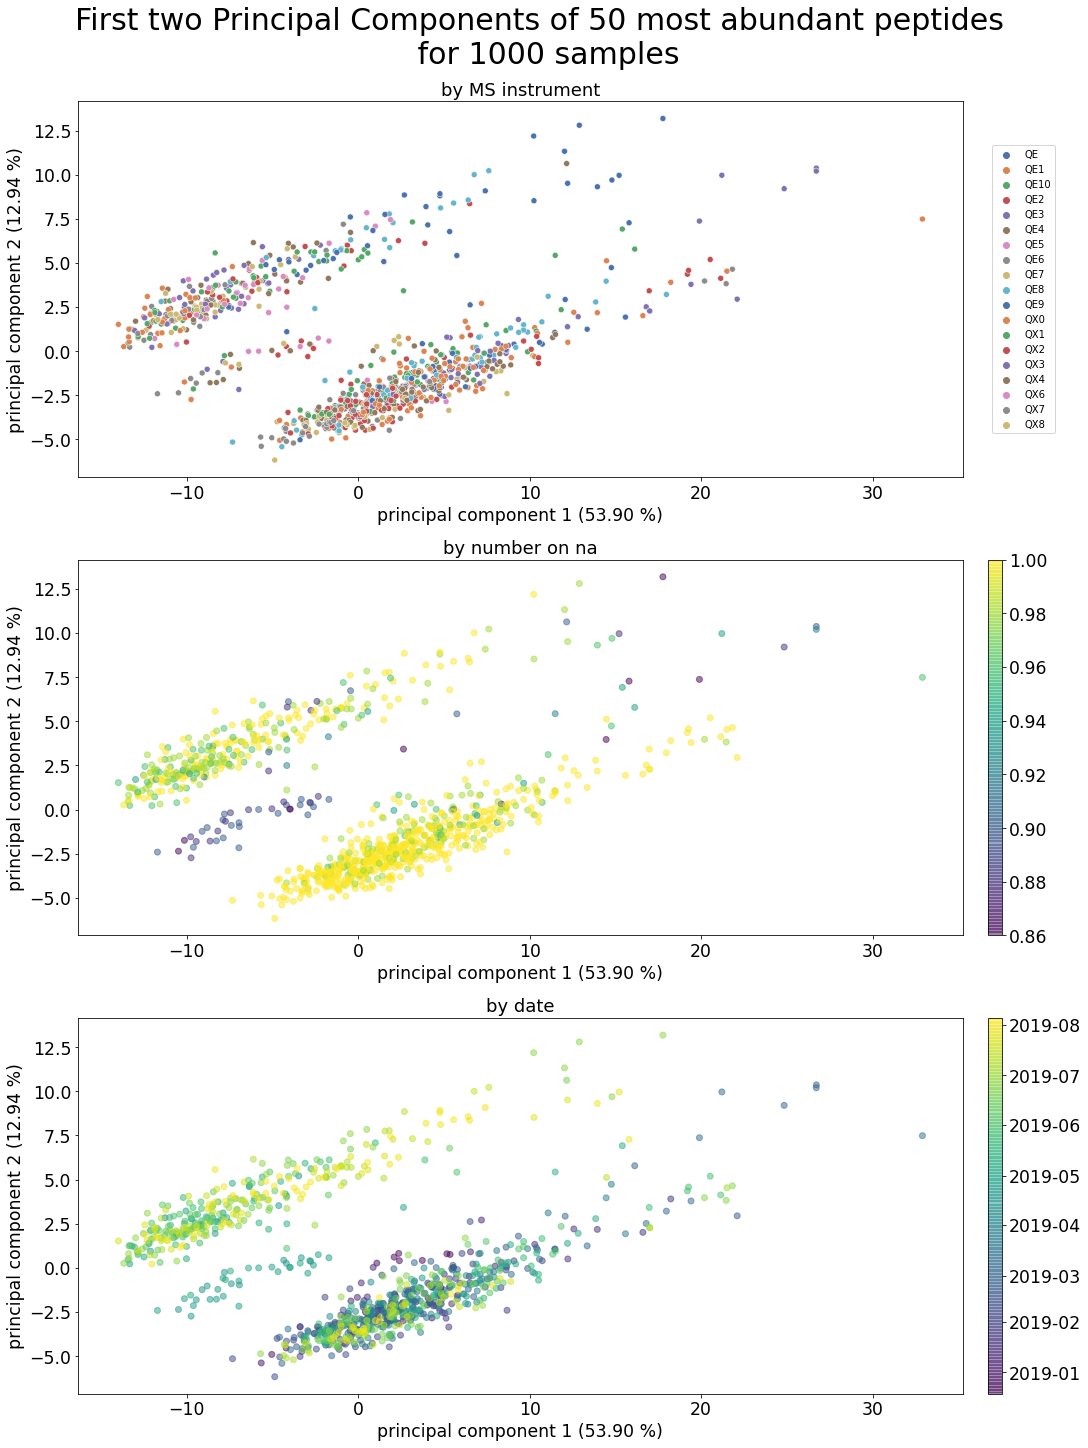

In [17]:
fig = analysis.plot_pca()

In [18]:
# ToDo add df_meta property
analysis.df_meta.describe()

,prop_not_na
count,"1,000.000"
mean,0.985
std,0.028
min,0.860
25%,0.980
50%,1.000
75%,1.000
max,1.000


In [19]:
vaep.io_images._savefig(fig, folder /
                        f'pca_plot_raw_data_{analysis.fname_stub}')

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\pca_plot_raw_data_N01000_M00050


## Train and Validation data

- use mulitindex for obtaining validation split

In [20]:
# analysis._df_long = analysis.df_long.reset_index(
# ).set_index(['Sample ID', 'peptide'])
analysis.df_long

intensity
Sample ID                           peptide                          
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 DLEEDHACIPIK               29.764
                                    TLTAVHDAILEDLVFPSEIVGK     30.168
                                    EQISDIDDAVR                29.423
                                    IGDLQAFQGHGAGNLAGLK        29.867
                                    TVLMNPNIASVQTNEVGLK        28.762
...                                                               ...
20190805_QE1_nLC2_AB_MNT_HELA_04    HEQNIDCGGGYVK              30.912
                                    ESEPQAAAEPAEAK             30.445
                                    AIVAIENPADVSVISSR          29.348
                                    TVTAMDVVYALK               34.581
                                    NSNLVGAAHEELQQSR           29.348

[49254 rows x 1 columns]

In [21]:
# df_long = analysis.df.unstack().to_frame('intensity').reset_index(1)
analysis.df_train = analysis.df_long.reset_index(0).groupby(
    by='Sample ID',
    level=0
).sample(frac=0.90,
         weights=freq_per_peptide,
         random_state=42)
analysis.df_train = analysis.df_train.reset_index().set_index([
    'Sample ID', 'peptide'])
analysis.df_train

,,intensity
Sample ID,peptide,
20190408_QE8_nLC14_AGF_QC_MNT_HeLa_50cm_01,AAVPSGASTGIYEALELRDNDK,33.111
20190730_QE6_nLC4_MPL_QC_MNT_HeLa_01,AAVPSGASTGIYEALELRDNDK,32.762
20190625_QE8_nLC14_GP_QC_MNT_15cm_Hela_01,AAVPSGASTGIYEALELRDNDK,32.950
20190603_QE3_nLC3_DS_QC_MNT_HeLa_03,AAVPSGASTGIYEALELRDNDK,32.237
20190207_QE8_nLC0_ASD_QC_HeLa_43cm3,AAVPSGASTGIYEALELRDNDK,32.427
...,...,...
20190626_QX8_ChDe_MA_HeLa_BR14_500ng,YNILGTNTIMDK,31.008
20190502_QX7_ChDe_MA_HeLa_500ng,YNILGTNTIMDK,31.911
20190408_QE7_nLC3_OOE_QC_MNT_HeLa_250ng_RO-006,YNILGTNTIMDK,30.754


In [22]:
analysis.indices_valid = analysis.df_long.index.difference(
    analysis.df_train.index)
analysis.df_valid = analysis.df_long.loc[analysis.indices_valid]

In [23]:
assert len(analysis.df_long) == len(analysis.df_train) + len(analysis.df_valid)

Check that all samples are also in the validation data

In [24]:
assert analysis.df_train.index.levshape == (N_SAMPLES, n_features)

try:
    assert analysis.df_valid.index.levshape == (N_SAMPLES, n_features)
except AssertionError:
    print(f'Expected shape in validation: {(N_SAMPLES, n_features)}')
    print(f'Shape in validation: {analysis.df_valid.index.levshape}')

analysis.df_train = analysis.df_train.loc[analysis.df_valid.index.levels[0]]
analysis.df_train = analysis.df_train.reset_index().set_index(
    ['Sample ID', 'peptide'])  # update index categories (there is probably a better way)
N_SAMPLES = analysis.df_valid.index.levshape[0]
analysis.df_train.index.levshape, analysis.df_valid.index.levshape

Expected shape in validation: (1000, 50)
Shape in validation: (995, 50)


((995, 50), (995, 50))

## Setup DL

- [ ] move all above to separate data notebook

In [25]:
import vaep.models as models
from vaep.models.cmd import get_args
from vaep.models import ae

args = get_args(batch_size=BATCH_SIZE, epochs=EPOCHS,
                no_cuda=False)  # data transfer to GPU seems slow
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

# torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda else "cpu")
device

print(f"{args = }", f"{device = }", sep='\n')

args = Namespace(batch_size=32, cuda=True, epochs=10, log_interval=10, no_cuda=False, seed=43)
device = device(type='cuda')


Fastai default device for computation

In [26]:
import fastai.torch_core
print(f"{torch.cuda.is_available() = }")  # self-documenting python 3.8
fastai.torch_core.defaults

torch.cuda.is_available() = True


namespace(cpus=12,
          use_cuda=None,
          activation=torch.nn.modules.activation.ReLU,
          callbacks=[fastai.callback.core.TrainEvalCallback,
                     fastai.learner.Recorder,
                     fastai.callback.progress.ProgressCallback],
          lr=0.001)

### Comparison data

- first impute first and last row (using n=3 replicate)
- use pandas interpolate

In [27]:
analysis.median_train = analysis.df_train['intensity'].unstack().median()
analysis.median_train.name = 'train_median'
analysis.averag_train = analysis.df_train['intensity'].unstack().mean()
analysis.averag_train.name = 'train_average'

df_pred = analysis.df_valid.copy()

df_pred = df_pred.join(analysis.median_train, on='peptide')
df_pred = df_pred.join(analysis.averag_train, on='peptide')


_ = interpolate(wide_df=analysis.df_train['intensity'].unstack())
df_pred = df_pred.join(_)

df_pred

intensity  \
Sample ID                           peptide                             
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK     31.358   
                                    DLEEDHACIPIK               29.764   
                                    FGYVDFESAEDLEK             29.106   
                                    IGDLQAFQGHGAGNLAGLK        29.867   
                                    SSEHINEGETAMLVCK           28.240   
...                                                               ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                 28.973   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                    31.110   
                                    KTEAPAAPAAQETK             31.690   
                                    QAQIEVVPSASALIIK           30.516   
                                    SSEHINEGETAMLVCK           29.820   

                                                            train_median  \
Sample ID                           peptide                                
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK        32.424   
                                    DLEEDHACIPIK                  30.036   
                                    FGYVDFESAEDLEK                30.022   
                                    IGDLQAFQGHGAGNLAGLK           30.666   
                                    SSEHINEGETAMLVCK              29.273   
...                                                                  ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                    28.941   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                       31.005   
                                    KTEAPAAPAAQETK                31.268   
                                    QAQIEVVPSASALIIK              30.019   
                                    SSEHINEGETAMLVCK              29.273   

                                                            train_average  \
Sample ID                           peptide                                 
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK         32.114   
                                    DLEEDHACIPIK                   30.528   
                                    FGYVDFESAEDLEK                 30.048   
                                    IGDLQAFQGHGAGNLAGLK            30.489   
                                    SSEHINEGETAMLVCK               28.994   
...                                                                   ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                     28.820   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                        30.981   
                                    KTEAPAAPAAQETK                 30.996   
                                    QAQIEVVPSASALIIK               29.921   
                                    SSEHINEGETAMLVCK               28.994   

                                                            replicates  
Sample ID                           peptide                             
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK      31.311  
                                    DLEEDHACIPIK                29.605  
                                    FGYVDFESAEDLEK              29.449  
                                    IGDLQAFQGHGAGNLAGLK         29.785  
                                    SSEHINEGETAMLVCK            28.558  
...                                                                ...  
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                  29.179  
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                     30.844  
                                    KTEAPAAPAAQETK              31.645  
                                    QAQIEVVPSASALIIK            30.723  
                                    SSEHINEGETAMLVCK            29.760  

[4923 rows x 4 columns]

In [28]:
if any(df_pred.isna()):
    print("Consecutive NaNs are not imputed using replicates.")
    display(df_pred.loc[df_pred.isna().any(axis=1)])

Consecutive NaNs are not imputed using replicates.


,,intensity,train_median,train_average,replicates
Sample ID,peptide,,,,
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_03,IIAPPERK,33.672,33.604,33.312,NaN
20190111_QE8_nLC1_ASD_QC_HeLa_01,SSEHINEGETAMLVCK,29.033,29.273,28.994,NaN
20190115_QE2_NLC10_TW_QC_MNT_HeLa_01,IWHHTFYNELR,32.853,32.452,32.051,NaN
20190118_QE1_nLC2_ANHO_QC_MNT_HELA_03,TATPQQAQEVHEK,29.824,31.988,31.839,NaN
20190122_QE6_nLC6_SIS_QC_MNT_HeLa_01,FGYVDFESAEDLEK,30.404,30.022,30.048,NaN
...,...,...,...,...,...
20190731_QE8_nLC14_ASD_QC_MNT_HeLa_03,FGYVDFESAEDLEK,29.393,30.022,30.048,NaN
20190731_QX8_ChSc_MA_HeLa_500ng,EMNDAAMFYTNR,29.605,27.322,27.360,NaN
20190801_QE9_nLC13_JM_MNT_MUC_Hela_15cm_01_20190801145136,NLDIERPTYTNLNR,32.004,31.915,31.857,NaN


## Collaboritive filtering model

In [29]:
from fastai.collab import CollabDataLoaders, MSELossFlat, Learner
from fastai.collab import EmbeddingDotBias

analysis.collab = Analysis()
collab = analysis.collab
collab.columns = 'peptide,Sample ID,intensity'.split(',')

Create data view for collaborative filtering

- currently a bit hacky as the splitter does not support predefinded indices (create custum subclass providing splits to internal methods?)

- Use the [`CollabDataLoaders`](https://docs.fast.ai/collab.html#CollabDataLoaders)  similar to the [`TabularDataLoaders`](https://docs.fast.ai/tabular.data.html#TabularDataLoaders).
- Use the [`IndexSplitter`](https://docs.fast.ai/data.transforms.html#IndexSplitter) and provide splits to whatever is used in `CollabDataLoaders`


In [30]:
collab.df_train = analysis.df_train.reset_index()
collab.df_valid = analysis.df_valid.reset_index()
collab.df_train.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AHSSMVGVNLPQK,29.899
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AIVAIENPADVSVISSR,29.292
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ALLFVPR,30.215
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ALTSEIALLQSR,27.244
4,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ASNGDAWVEAHGK,24.793


In [31]:
collab.df_valid.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AAVPSGASTGIYEALELRDNDK,31.358
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,DLEEDHACIPIK,29.764
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,FGYVDFESAEDLEK,29.106
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,IGDLQAFQGHGAGNLAGLK,29.867
4,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,SSEHINEGETAMLVCK,28.240


In [32]:
assert (collab.df_train.intensity.isna().sum(),
        collab.df_valid.intensity.isna().sum()) == (0, 0), "Remove missing values."

Hacky part uses training data `Datasets` from dataloaders to recreate a custom `DataLoaders` instance

In [33]:
collab.dl_train = CollabDataLoaders.from_df(
    collab.df_train, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size, device=device)
collab.dl_valid = CollabDataLoaders.from_df(
    collab.df_valid, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size,
    shuffle=False, device=device)
collab.dl_train.show_batch()

,Sample ID,peptide,intensity
0,20190115_QE2_NLC10_TW_QC_MNT_HeLa_01,IYVDDGLISLQVK,31.065
1,20190221_QE8_nLC9_JM_QC_MNT_HeLa_01_20190222005035,ASNGDAWVEAHGK,29.153
2,20190121_QE2_NLC1_GP_QC_MNT_HELA_02,DHENIVIAK,29.485
3,20190206_QE9_nLC9_NHS_MNT_HELA_50cm_Newcolm2_1,KQELEEICHDLEAR,25.993
4,20190717_QE6_LC4_SCL_QC_MNT_Hela_04,SHTILLVQPTK,29.245
5,20190425_QX8_JuSc_MA_HeLa_500ng_1,TLTAVHDAILEDLVFPSEIVGK,31.826
6,20190425_QE9_nLC0_LiNi_QC_45cm_HeLa_01,LMDVGLIAIR,28.017
7,20190729_QX2_IgPa_MA_HeLa_500ng_CTCDoff_LC05,SLEDQVEMLR,28.351
8,20190208_QE2_NLC1_AB_QC_MNT_HELA_3,MALIGLGVSHPVLK,28.828
9,20190712_QE1_nLC13_ANHO_QC_MNT_HELA_03,LLLGAGAVAYGVR,26.696


In [34]:
from fastai.data.core import DataLoaders
collab.dls = DataLoaders(collab.dl_train.train, collab.dl_valid.train)
if args.cuda:
    collab.dls.cuda()

In [35]:
collab.dl_valid.show_batch()

,Sample ID,peptide,intensity
0,20190219_QE10_nLC14_FaCo_QC_HeLa_50cm_20190221093339,MALIGLGVSHPVLK,26.963
1,20190527_QX4_IgPa_MA_HeLa_500ng,NYIQGINLVQAK,30.123
2,20190420_QE8_nLC14_RG_QC_HeLa_01,LLLGAGAVAYGVR,28.125
3,20190228_QE1_nLC2_ANHO_QC_MNT_HELA_01,IYVDDGLISLQVK,28.075
4,20190726_QX8_ChSc_MA_HeLa_500ng,YNILGTNTIMDK,31.638
5,20190702_QE3_nLC5_GF_QC_MNT_Hela_01,FQSSHHPTDITSLDQYVER,25.505
6,20190218_QE6_LC6_SCL_MVM_QC_MNT_Hela_02,IGDLQAFQGHGAGNLAGLK,30.671
7,20190225_QE10_PhGe_Evosep_88min_HeLa_9,TYFSCTSAHTSTGDGTAMITR,28.220
8,20190205_QE7_nLC7_MEM_QC_MNT_HeLa_02,SLEDQVEMLR,29.713
9,20190425_QX8_JuSc_MA_HeLa_500ng_1,ALLFVPR,32.193


In [36]:
len(collab.dls.classes['Sample ID']), len(collab.dls.classes['peptide'])

(996, 51)

In [37]:
len(collab.dls.train), len(collab.dls.valid)  # mini-batches

(1377, 154)

Alternatively to the hacky version, one could use a factory method, but there the sampling/Splitting methods would need to be implemented (not using [`RandomSplitter`](https://docs.fast.ai/data.transforms.html#RandomSplitter) somehow)

 - [`TabDataLoader`](https://docs.fast.ai/tabular.core.html#TabDataLoader)
 - uses [`TabularPandas`](https://docs.fast.ai/tabular.core.html#TabularPandas)
 
 > Current problem: No custom splitter can be provided

### Model

In [38]:
collab.model_args = {}
collab.model_args['n_samples'] = len(collab.dls.classes['Sample ID'])
collab.model_args['n_peptides'] = len(collab.dls.classes['peptide'])
collab.model_args['dim_latent_factors'] = latent_dim
collab.model_args['y_range'] = (
    int(analysis.df_train['intensity'].min()), int(analysis.df_train['intensity'].max())+1)

print("Args:")
pprint(collab.model_args)


# from vaep.models.collab import DotProductBias
# model = DotProductBias(**collab.model_args)
model = EmbeddingDotBias.from_classes(
    n_factors=collab.model_args['dim_latent_factors'], classes=collab.dls.classes, y_range=collab.model_args['y_range'])
learn = Learner(dls=collab.dls, model=model, loss_func=MSELossFlat())
if args.cuda:
    learn.cuda()
learn.summary()

Args:
{'dim_latent_factors': 2,
 'n_peptides': 51,
 'n_samples': 996,
 'y_range': (20, 36)}


EmbeddingDotBias (Input shape: 32 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 2              
Embedding                                 1992       True      
Embedding                                 102        True      
____________________________________________________________________________
                     32 x 1              
Embedding                                 996        True      
Embedding                                 51         True      
____________________________________________________________________________

Total params: 3,141
Total trainable params: 3,141
Total non-trainable params: 0

Optimizer used: <function Adam at 0x000001E86F527040>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

### Training

In [39]:
learn.fit_one_cycle(epochs_max, 5e-3)

epoch,train_loss,valid_loss,time
0,2.149426,1.949176,00:08
1,0.960952,0.932606,00:08
2,0.667276,0.766322,00:09
3,0.615933,0.677470,00:09
4,0.699376,0.644258,00:08
5,0.610011,0.619976,00:09
6,0.628306,0.609396,00:08
7,0.545831,0.602385,00:08
8,0.553660,0.598564,00:08
9,0.625164,0.598479,00:08


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_training


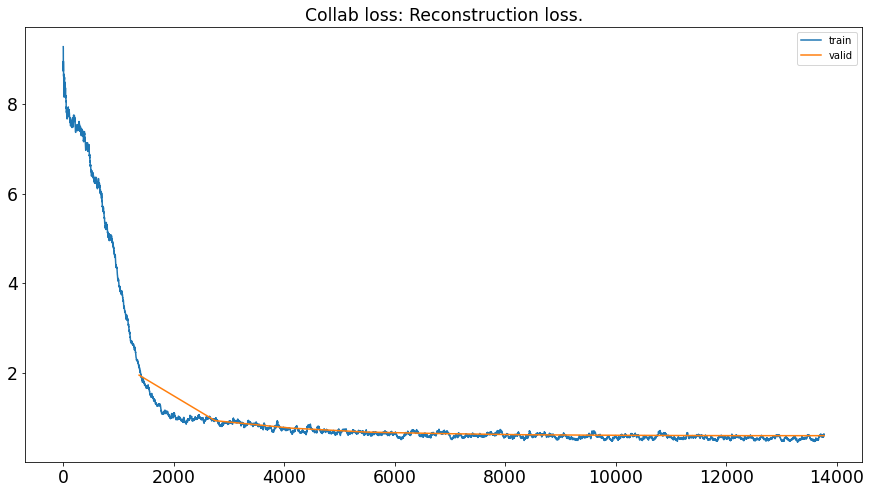

In [40]:
from vaep.models import plot_loss
from fastai import learner
learner.Recorder.plot_loss = plot_loss

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('Collab loss: Reconstruction loss.')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='collab_training',
                        folder=folder)

### Evaluation

In [41]:
collab.dls.valid_ds.items

,Sample ID,peptide,intensity
923,185,32,26.963
"2,935",594,36,30.123
"2,009",405,30,28.125
"1,238",247,26,28.075
"4,619",936,50,31.638
...,...,...,...
"4,761",964,42,30.201
"2,889",585,25,29.412
"3,877",787,23,33.311
"2,699",542,45,32.888


In [42]:
df_pred = df_pred.reset_index()
pred, target = learn.get_preds()
df_pred['intensity_pred_collab'] = pd.Series(
    pred.flatten().numpy(), index=collab.dls.valid.items.index)

npt.assert_almost_equal(
    actual=collab.dls.valid.items.intensity.to_numpy(),
    desired=target.numpy().flatten()
)


df_pred = analyzers.cast_object_to_category(df_pred)
df_pred.set_index(['Sample ID', 'peptide'], inplace=True)
df_pred

intensity  \
Sample ID                           peptide                             
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK     31.358   
                                    DLEEDHACIPIK               29.764   
                                    FGYVDFESAEDLEK             29.106   
                                    IGDLQAFQGHGAGNLAGLK        29.867   
                                    SSEHINEGETAMLVCK           28.240   
...                                                               ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                 28.973   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                    31.110   
                                    KTEAPAAPAAQETK             31.690   
                                    QAQIEVVPSASALIIK           30.516   
                                    SSEHINEGETAMLVCK           29.820   

                                                            train_median  \
Sample ID                           peptide                                
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK        32.424   
                                    DLEEDHACIPIK                  30.036   
                                    FGYVDFESAEDLEK                30.022   
                                    IGDLQAFQGHGAGNLAGLK           30.666   
                                    SSEHINEGETAMLVCK              29.273   
...                                                                  ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                    28.941   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                       31.005   
                                    KTEAPAAPAAQETK                31.268   
                                    QAQIEVVPSASALIIK              30.019   
                                    SSEHINEGETAMLVCK              29.273   

                                                            train_average  \
Sample ID                           peptide                                 
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK         32.114   
                                    DLEEDHACIPIK                   30.528   
                                    FGYVDFESAEDLEK                 30.048   
                                    IGDLQAFQGHGAGNLAGLK            30.489   
                                    SSEHINEGETAMLVCK               28.994   
...                                                                   ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                     28.820   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                        30.981   
                                    KTEAPAAPAAQETK                 30.996   
                                    QAQIEVVPSASALIIK               29.921   
                                    SSEHINEGETAMLVCK               28.994   

                                                            replicates  \
Sample ID                           peptide                              
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK      31.311   
                                    DLEEDHACIPIK                29.605   
                                    FGYVDFESAEDLEK              29.449   
                                    IGDLQAFQGHGAGNLAGLK         29.785   
                                    SSEHINEGETAMLVCK            28.558   
...                                                                ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                  29.179   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                     30.844   
                                    KTEAPAAPAAQETK              31.645   
                                    QAQIEVVPSASALIIK            30.723   
                                    SSEHINEGETAMLVCK            29.760   

                                                            intensity_pred_collab  
Sample ID                           peptide                             

In [43]:
assert (abs(target.reshape(-1) - pred.reshape(-1))).sum() / len(target) - \
    (df_pred.intensity - df_pred.intensity_pred_collab).abs().sum() / \
    len(df_pred) < 0.00001

### Plot biases and embedding weigths

- visualize relative order of samples and peptides

In [44]:
from collections import namedtuple
def get_bias(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.bias(indices.values, is_item=is_item) # user=sample
    return pd.Series(ret, index=indices)

# def get_weigths

CollabIDs = namedtuple("CollabIDs", "sample peptide")

collab.biases = CollabIDs(
    sample=get_bias(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_bias(learn, indices=analysis.df_train.index.levels[1] )
)
collab.biases.sample.head()

Sample ID
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02     0.157
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01    0.172
20181221_QE8_nLC0_NHS_MNT_HeLa_01       0.248
20181222_QE9_nLC9_QC_50CM_HeLa1         0.260
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01   0.221
dtype: float32

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_samples


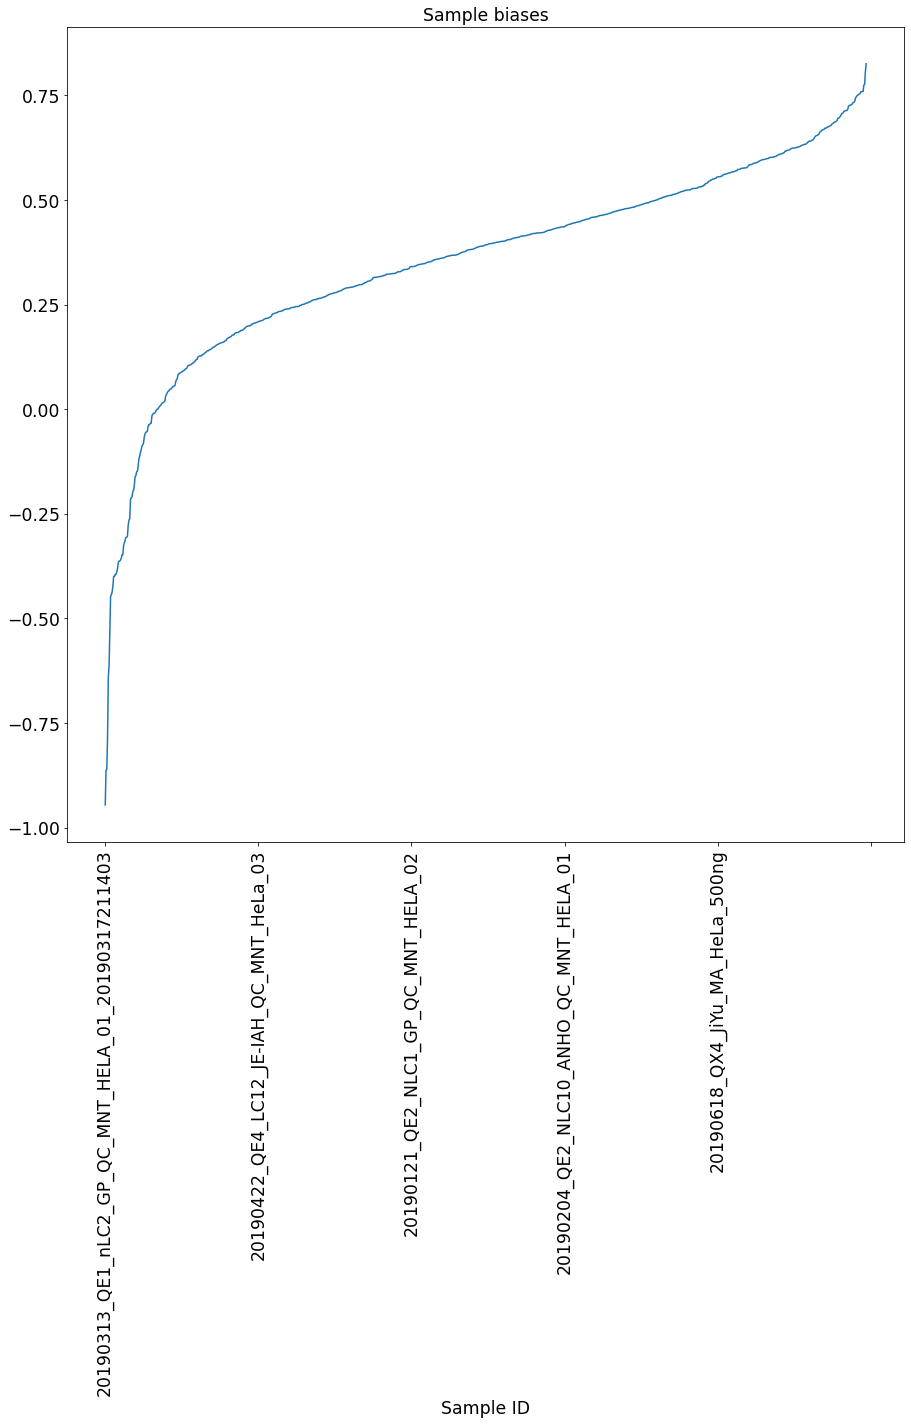

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = collab.biases.sample.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_samples',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_peptides


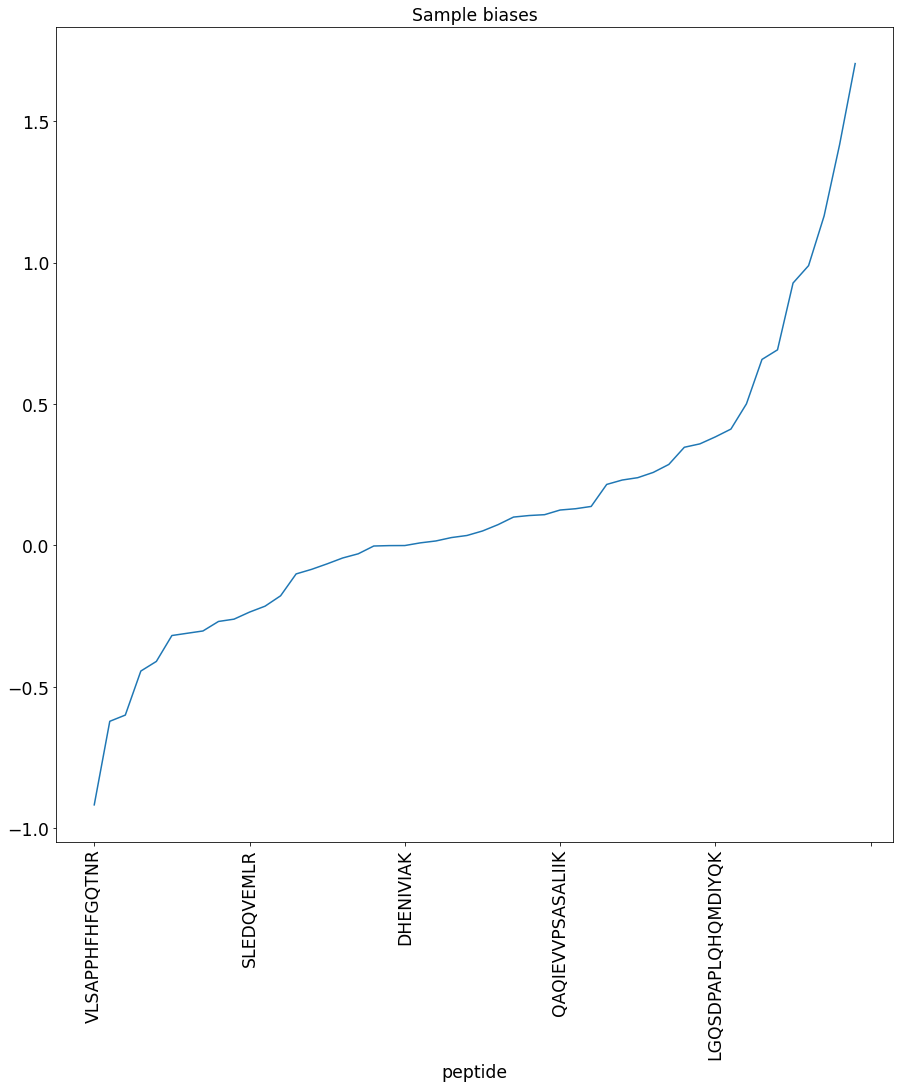

In [46]:
fig, ax = plt.subplots(figsize=(15, 15))
_ = collab.biases.peptide.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_peptides',
                        folder=folder)

In [47]:
def get_weight(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.weight(indices.values, is_item=is_item) # user=sample
    return pd.DataFrame(ret, index=indices, columns=[f'latent dimension {i+1}' for i in range(ret.shape[-1])])

collab.embeddings = CollabIDs(
    sample=get_weight(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_weight(learn, indices=analysis.df_train.index.levels[1] )
)
collab.embeddings.sample.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.130,0.068
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,0.150,0.122
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.134,-0.049
20181222_QE9_nLC9_QC_50CM_HeLa1,0.099,0.037
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.119,0.203


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_date


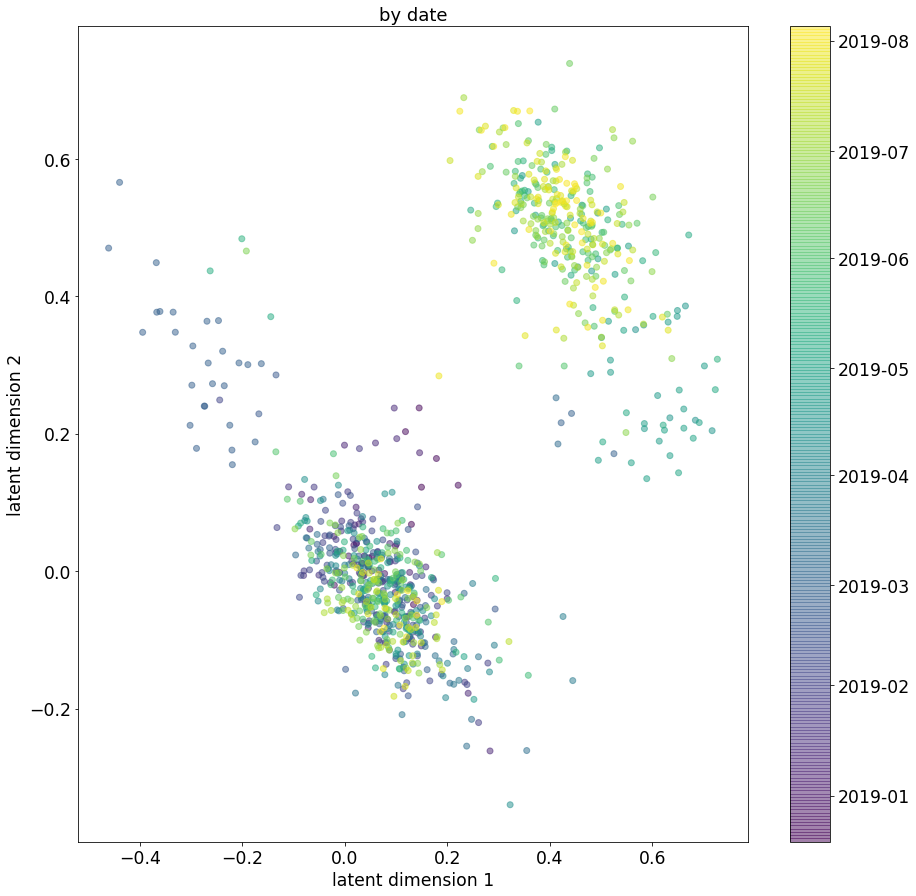

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=collab.embeddings.sample, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[collab.embeddings.sample.index])
vaep.io_images._savefig(fig, name='collab_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_ms_instrument


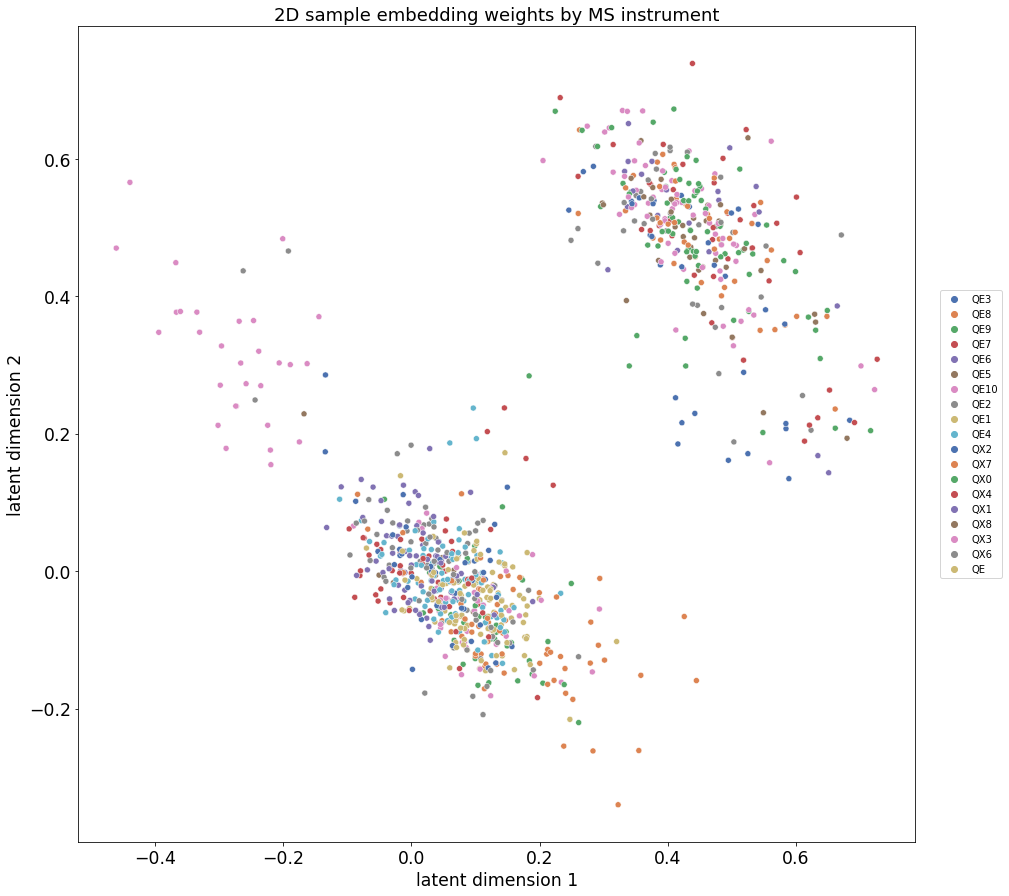

In [49]:
fig, ax = plt.subplots(figsize=(15, 15))
meta_col = 'ms_instrument'

df_ = collab.embeddings.sample
analyzers.seaborn_scatter(df=df_,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_.index],
                          title='2D sample embedding weights by MS instrument')

vaep.io_images._savefig(fig, name='collab_latent_by_ms_instrument',
                        folder=folder)

## Denoising Autoencoder (DAE)

### Custom Transforms

- [x] Shift standard normalized data around
    - Error metrics won't be directly comparable afterwards

In [50]:
from fastai.tabular.all import *
from vaep.models import ae

from fastai.tabular.core import TabularPandas

# from fastai.callback.core import Callback

from fastai.data.core import DataLoaders

from fastai.learner import Learner
from fastai.losses import MSELossFlat


# https://docs.fast.ai/tabular.core.html#FillStrategy
# from fastai.tabular.core import FillMissing
# from fastai.tabular.core import TabularPandas

### DataLoaders

In [51]:
# revert format
# undo using `stack`
analysis.df_train = analysis.df_train['intensity'].unstack()
analysis.df_valid = analysis.df_valid['intensity'].unstack()
analysis.df_valid.head()

peptide,AAVPSGASTGIYEALELRDNDK,AHSSMVGVNLPQK,AIVAIENPADVSVISSR,ALLFVPR,ALPAVQQNNLDEDLIRK,ALTSEIALLQSR,ASNGDAWVEAHGK,DHENIVIAK,DLEEDHACIPIK,DSYVGDEAQSK,...,SHTILLVQPTK,SLEDQVEMLR,SSEHINEGETAMLVCK,TATPQQAQEVHEK,TLTAVHDAILEDLVFPSEIVGK,TVLMNPNIASVQTNEVGLK,TVTAMDVVYALK,TYFSCTSAHTSTGDGTAMITR,VLSAPPHFHFGQTNR,YNILGTNTIMDK
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,31.358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.764,NaN,...,NaN,NaN,28.240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,30.042,NaN,NaN,28.627,NaN,25.114,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,32.533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.960
20181222_QE9_nLC9_QC_50CM_HeLa1,31.781,NaN,NaN,30.176,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.326
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mean and std. dev. from training data

In [52]:
# norm = Normalize.from_stats(analysis.df_train.mean(), analysis.df_valid.std()) # copy interface?
NORMALIZER = Normalize  # dae.NormalizeShiftedMean

#### Training data

procs passed to TabluarPandas are handled internally 
  1. not necessarily in order
  2. with setup call (using current training data)

In [53]:
procs = [NORMALIZER, FillMissing(add_col=True)]
cont_names = list(analysis.df_train.columns)

to = TabularPandas(analysis.df_train, procs=procs, cont_names=cont_names)
print("Tabular object:", type(to))

to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,AAVPSGASTGIYEALELRDNDK,AHSSMVGVNLPQK,AIVAIENPADVSVISSR,ALLFVPR,ALPAVQQNNLDEDLIRK,ALTSEIALLQSR,ASNGDAWVEAHGK,DHENIVIAK,DLEEDHACIPIK,DSYVGDEAQSK,...,SHTILLVQPTK_na,SLEDQVEMLR_na,SSEHINEGETAMLVCK_na,TATPQQAQEVHEK_na,TLTAVHDAILEDLVFPSEIVGK_na,TVLMNPNIASVQTNEVGLK_na,TVTAMDVVYALK_na,TYFSCTSAHTSTGDGTAMITR_na,VLSAPPHFHFGQTNR_na,YNILGTNTIMDK_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.227,-0.320,-0.770,-0.706,0.078,-1.041,-2.142,-0.486,-0.250,-0.571,...,False,False,True,False,False,False,False,False,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.724,0.015,-0.828,-0.724,0.078,-1.227,-0.016,-0.295,-0.275,-0.479,...,False,False,False,False,False,False,False,False,False,False
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.227,-0.252,0.039,-0.475,-0.227,-0.475,-1.770,-0.864,-0.710,0.125,...,False,False,False,False,False,False,False,False,False,True
20181222_QE9_nLC9_QC_50CM_HeLa1,0.227,0.101,-0.286,0.020,-0.342,-0.848,-0.303,-2.240,-1.596,-0.068,...,False,False,False,False,False,False,False,False,False,True
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.207,-0.145,-0.481,-0.474,0.078,-0.873,-0.203,-0.549,-0.315,-0.406,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,-0.197,-0.226,0.988,0.590,0.605,0.013,1.312,0.531,-0.250,0.187,...,False,False,False,False,True,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_01,0.220,0.578,-1.399,-0.622,-0.179,-0.176,0.165,-0.035,-0.358,0.231,...,True,False,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_02,0.156,0.386,-0.901,-0.134,-3.349,-0.160,0.164,0.333,-0.287,0.441,...,False,False,False,False,False,False,False,False,False,False


Better manuelly apply `Transforms` on `Tabluar` type

In [54]:
cont_names = list(analysis.df_train.columns)
to = TabularPandas(analysis.df_train, cont_names=cont_names, do_setup=False)

tf_norm = NORMALIZER()
_ = tf_norm.setups(to)  # returns to
tf_fillna = FillMissing(add_col=True)
_ = tf_fillna.setup(to)

print("Tabular object:", type(to))
# _ = (procs[0]).encodes(to)
to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,AAVPSGASTGIYEALELRDNDK,AHSSMVGVNLPQK,AIVAIENPADVSVISSR,ALLFVPR,ALPAVQQNNLDEDLIRK,ALTSEIALLQSR,ASNGDAWVEAHGK,DHENIVIAK,DLEEDHACIPIK,DSYVGDEAQSK,...,SHTILLVQPTK_na,SLEDQVEMLR_na,SSEHINEGETAMLVCK_na,TATPQQAQEVHEK_na,TLTAVHDAILEDLVFPSEIVGK_na,TVLMNPNIASVQTNEVGLK_na,TVTAMDVVYALK_na,TYFSCTSAHTSTGDGTAMITR_na,VLSAPPHFHFGQTNR_na,YNILGTNTIMDK_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.246,-0.302,-0.732,-0.664,0.083,-0.984,-2.017,-0.462,-0.265,-0.522,...,False,False,True,False,False,False,False,False,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.639,0.015,-0.787,-0.681,0.083,-1.160,-0.017,-0.282,-0.289,-0.434,...,False,False,False,False,False,False,False,False,False,False
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.246,-0.237,0.033,-0.446,-0.206,-0.448,-1.668,-0.818,-0.702,0.139,...,False,False,False,False,False,False,False,False,False,True
20181222_QE9_nLC9_QC_50CM_HeLa1,0.246,0.097,-0.273,0.021,-0.314,-0.801,-0.287,-2.114,-1.545,-0.044,...,False,False,False,False,False,False,False,False,False,True
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.158,-0.136,-0.459,-0.445,0.083,-0.825,-0.193,-0.521,-0.327,-0.365,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,-0.148,-0.213,0.932,0.559,0.581,0.013,1.233,0.496,-0.265,0.198,...,False,False,False,False,True,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_01,0.240,0.550,-1.327,-0.584,-0.160,-0.165,0.154,-0.037,-0.367,0.240,...,True,False,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_02,0.180,0.368,-0.856,-0.124,-3.156,-0.150,0.152,0.309,-0.300,0.439,...,False,False,False,False,False,False,False,False,False,False


Check mean and standard deviation after normalization

In [55]:
to.items.iloc[:, :10].describe()  # not perferct anymore as expected

peptide,AAVPSGASTGIYEALELRDNDK,AHSSMVGVNLPQK,AIVAIENPADVSVISSR,ALLFVPR,ALPAVQQNNLDEDLIRK,ALTSEIALLQSR,ASNGDAWVEAHGK,DHENIVIAK,DLEEDHACIPIK,DSYVGDEAQSK
count,995.000,995.000,995.000,995.000,995.000,995.000,995.000,995.000,995.000,995.000
mean,0.035,0.002,-0.003,0.002,0.009,0.001,-0.002,-0.004,-0.027,0.021
std,0.931,0.949,0.947,0.944,0.946,0.947,0.941,0.943,0.951,0.950
min,-6.199,-4.651,-4.364,-5.286,-4.314,-4.594,-2.939,-4.518,-3.095,-6.824
25%,-0.150,-0.446,-0.458,-0.392,-0.321,-0.410,-0.452,-0.419,-0.554,-0.208
50%,0.246,0.015,-0.030,0.021,0.083,0.013,-0.017,-0.037,-0.265,0.203
75%,0.556,0.578,0.498,0.533,0.508,0.488,0.529,0.533,0.830,0.550
max,1.702,2.215,2.348,1.916,1.763,2.650,1.976,2.417,1.929,1.715


Mask is added as type bool

In [56]:
to.items.dtypes.value_counts()

float64   50
bool      50
dtype: int64

with the suffix `_na` where `True` is indicating a missing value replaced by the `FillMissing` transformation

In [57]:
to.cont_names, to.cat_names

((#50) ['AAVPSGASTGIYEALELRDNDK','AHSSMVGVNLPQK','AIVAIENPADVSVISSR','ALLFVPR','ALPAVQQNNLDEDLIRK','ALTSEIALLQSR','ASNGDAWVEAHGK','DHENIVIAK','DLEEDHACIPIK','DSYVGDEAQSK'...],
 (#50) ['AAVPSGASTGIYEALELRDNDK_na','AHSSMVGVNLPQK_na','AIVAIENPADVSVISSR_na','ALLFVPR_na','ALPAVQQNNLDEDLIRK_na','ALTSEIALLQSR_na','ASNGDAWVEAHGK_na','DHENIVIAK_na','DLEEDHACIPIK_na','DSYVGDEAQSK_na'...])

In [58]:
assert len(to.valid) == 0

#### Validation data

- reuse training data with different mask for evaluation
- target data is the validation data
    - switch between training and evaluation mode for setting comparison

In [59]:
_df_valid = TabularPandas(
    analysis.df_valid, cont_names=analysis.df_valid.columns.tolist())
# assert analysis.df_valid.isna().equals(y_valid.items.isna())
_df_valid = tf_norm.encodes(_df_valid)

In [60]:
_df_valid.items.iloc[:, :10].describe()

peptide,AAVPSGASTGIYEALELRDNDK,AHSSMVGVNLPQK,AIVAIENPADVSVISSR,ALLFVPR,ALPAVQQNNLDEDLIRK,ALTSEIALLQSR,ASNGDAWVEAHGK,DHENIVIAK,DLEEDHACIPIK,DSYVGDEAQSK
count,95.000,100.000,99.000,99.000,99.000,99.000,98.000,99.000,100.000,100.000
mean,0.132,0.062,0.146,-0.101,0.025,0.102,-0.169,-0.071,0.001,-0.249
std,0.888,0.958,1.001,1.002,0.930,1.088,1.188,0.974,1.002,1.097
min,-3.948,-2.954,-3.097,-4.975,-3.556,-4.307,-2.725,-3.751,-1.785,-5.136
25%,-0.197,-0.323,-0.551,-0.579,-0.368,-0.481,-1.219,-0.551,-0.689,-0.424
50%,0.340,0.076,0.087,0.021,0.094,0.049,-0.077,-0.163,-0.293,0.032
75%,0.689,0.720,0.876,0.494,0.473,0.925,0.859,0.598,1.093,0.331
max,1.772,1.987,1.997,2.133,1.531,2.079,1.640,2.061,1.726,1.244


In [61]:
# Validation dataset
# build validation DataFrame with mask according to validation data
# FillNA values in data as before, but do not add categorical columns (as this is done manuelly)
_valid_df = to.conts  # same data for predictions
_valid_df = _valid_df.join(analysis.df_valid.isna(), rsuffix='_na')  # mask
_valid_df = _valid_df.join(_df_valid.items, rsuffix='_val')  # target
_valid_df

peptide,AAVPSGASTGIYEALELRDNDK,AHSSMVGVNLPQK,AIVAIENPADVSVISSR,ALLFVPR,ALPAVQQNNLDEDLIRK,ALTSEIALLQSR,ASNGDAWVEAHGK,DHENIVIAK,DLEEDHACIPIK,DSYVGDEAQSK,...,SHTILLVQPTK_val,SLEDQVEMLR_val,SSEHINEGETAMLVCK_val,TATPQQAQEVHEK_val,TLTAVHDAILEDLVFPSEIVGK_val,TVLMNPNIASVQTNEVGLK_val,TVTAMDVVYALK_val,TYFSCTSAHTSTGDGTAMITR_val,VLSAPPHFHFGQTNR_val,YNILGTNTIMDK_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.246,-0.302,-0.732,-0.664,0.083,-0.984,-2.017,-0.462,-0.265,-0.522,...,NaN,NaN,-0.616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.639,0.015,-0.787,-0.681,0.083,-1.160,-0.017,-0.282,-0.289,-0.434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.246,-0.237,0.033,-0.446,-0.206,-0.448,-1.668,-0.818,-0.702,0.139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.400
20181222_QE9_nLC9_QC_50CM_HeLa1,0.246,0.097,-0.273,0.021,-0.314,-0.801,-0.287,-2.114,-1.545,-0.044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.966
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.158,-0.136,-0.459,-0.445,0.083,-0.825,-0.193,-0.521,-0.327,-0.365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,-0.148,-0.213,0.932,0.559,0.581,0.013,1.233,0.496,-0.265,0.198,...,NaN,NaN,NaN,NaN,0.571,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_01,0.240,0.550,-1.327,-0.584,-0.160,-0.165,0.154,-0.037,-0.367,0.240,...,-0.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_02,0.180,0.368,-0.856,-0.124,-3.156,-0.150,0.152,0.309,-0.300,0.439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# [norm, FillMissing(add_col=False)]  # mask is provided explicitly
procs = None

cont_names = list(analysis.df_train.columns)
cat_names = [f'{s}_na' for s in cont_names]
y_names = [f'{s}_val' for s in cont_names]

splits = None
y_block = None
to_valid = TabularPandas(_valid_df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                         y_names=y_names, splits=splits, y_block=y_block, do_setup=True)
to_valid.items

peptide,AAVPSGASTGIYEALELRDNDK,AHSSMVGVNLPQK,AIVAIENPADVSVISSR,ALLFVPR,ALPAVQQNNLDEDLIRK,ALTSEIALLQSR,ASNGDAWVEAHGK,DHENIVIAK,DLEEDHACIPIK,DSYVGDEAQSK,...,SHTILLVQPTK_val,SLEDQVEMLR_val,SSEHINEGETAMLVCK_val,TATPQQAQEVHEK_val,TLTAVHDAILEDLVFPSEIVGK_val,TVLMNPNIASVQTNEVGLK_val,TVTAMDVVYALK_val,TYFSCTSAHTSTGDGTAMITR_val,VLSAPPHFHFGQTNR_val,YNILGTNTIMDK_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.246,-0.302,-0.732,-0.664,0.083,-0.984,-2.017,-0.462,-0.265,-0.522,...,NaN,NaN,-0.616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.639,0.015,-0.787,-0.681,0.083,-1.160,-0.017,-0.282,-0.289,-0.434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.246,-0.237,0.033,-0.446,-0.206,-0.448,-1.668,-0.818,-0.702,0.139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.400
20181222_QE9_nLC9_QC_50CM_HeLa1,0.246,0.097,-0.273,0.021,-0.314,-0.801,-0.287,-2.114,-1.545,-0.044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.966
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.158,-0.136,-0.459,-0.445,0.083,-0.825,-0.193,-0.521,-0.327,-0.365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,-0.148,-0.213,0.932,0.559,0.581,0.013,1.233,0.496,-0.265,0.198,...,NaN,NaN,NaN,NaN,0.571,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_01,0.240,0.550,-1.327,-0.584,-0.160,-0.165,0.154,-0.037,-0.367,0.240,...,-0.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_02,0.180,0.368,-0.856,-0.124,-3.156,-0.150,0.152,0.309,-0.300,0.439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
stats_valid = to_valid.targ.iloc[:, :100].describe()
stats_valid

peptide,AAVPSGASTGIYEALELRDNDK_val,AHSSMVGVNLPQK_val,AIVAIENPADVSVISSR_val,ALLFVPR_val,ALPAVQQNNLDEDLIRK_val,ALTSEIALLQSR_val,ASNGDAWVEAHGK_val,DHENIVIAK_val,DLEEDHACIPIK_val,DSYVGDEAQSK_val,...,SHTILLVQPTK_val,SLEDQVEMLR_val,SSEHINEGETAMLVCK_val,TATPQQAQEVHEK_val,TLTAVHDAILEDLVFPSEIVGK_val,TVLMNPNIASVQTNEVGLK_val,TVTAMDVVYALK_val,TYFSCTSAHTSTGDGTAMITR_val,VLSAPPHFHFGQTNR_val,YNILGTNTIMDK_val
count,95.000,100.000,99.000,99.000,99.000,99.000,98.000,99.000,100.000,100.000,...,99.000,98.000,100.000,100.000,96.000,100.000,100.000,99.000,91.000,100.000
mean,0.132,0.062,0.146,-0.101,0.025,0.102,-0.169,-0.071,0.001,-0.249,...,-0.065,-0.162,0.178,0.003,-0.145,0.031,0.106,-0.205,-0.184,0.056
std,0.888,0.958,1.001,1.002,0.930,1.088,1.188,0.974,1.002,1.097,...,1.071,1.100,1.008,0.915,1.086,0.979,1.100,1.009,0.958,0.985
min,-3.948,-2.954,-3.097,-4.975,-3.556,-4.307,-2.725,-3.751,-1.785,-5.136,...,-2.920,-3.281,-5.625,-2.865,-3.388,-2.990,-3.800,-3.795,-2.295,-2.378
25%,-0.197,-0.323,-0.551,-0.579,-0.368,-0.481,-1.219,-0.551,-0.689,-0.424,...,-0.747,-0.922,-0.066,-0.469,-0.673,-0.421,-0.129,-0.702,-0.811,-0.630
50%,0.340,0.076,0.087,0.021,0.094,0.049,-0.077,-0.163,-0.293,0.032,...,-0.331,0.027,0.285,0.100,0.149,0.000,0.423,0.077,-0.555,0.106
75%,0.689,0.720,0.876,0.494,0.473,0.925,0.859,0.598,1.093,0.331,...,1.063,0.662,0.812,0.644,0.497,0.515,0.826,0.478,0.150,0.901
max,1.772,1.987,1.997,2.133,1.531,2.079,1.640,2.061,1.726,1.244,...,1.896,1.708,1.614,1.665,2.054,1.868,1.772,1.474,1.721,1.900


In [64]:
# True = training data ("fill_na" transform sets mask to true in training data where values are replaced)
to_valid.cats

peptide,AAVPSGASTGIYEALELRDNDK_na,AHSSMVGVNLPQK_na,AIVAIENPADVSVISSR_na,ALLFVPR_na,ALPAVQQNNLDEDLIRK_na,ALTSEIALLQSR_na,ASNGDAWVEAHGK_na,DHENIVIAK_na,DLEEDHACIPIK_na,DSYVGDEAQSK_na,...,SHTILLVQPTK_na,SLEDQVEMLR_na,SSEHINEGETAMLVCK_na,TATPQQAQEVHEK_na,TLTAVHDAILEDLVFPSEIVGK_na,TVLMNPNIASVQTNEVGLK_na,TVTAMDVVYALK_na,TYFSCTSAHTSTGDGTAMITR_na,VLSAPPHFHFGQTNR_na,YNILGTNTIMDK_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,False,True,True,True,True,True,True,True,False,True,...,True,True,False,True,True,True,True,True,True,True
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,True,False,True,True,False,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
20181221_QE8_nLC0_NHS_MNT_HeLa_01,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
20181222_QE9_nLC9_QC_50CM_HeLa1,False,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,True,True,True,True,True,False,True,True,False,True,...,True,True,True,True,False,True,True,True,True,True
20190805_QE1_nLC2_AB_MNT_HELA_01,True,True,True,True,True,True,True,False,True,True,...,False,True,True,True,True,True,True,True,True,True
20190805_QE1_nLC2_AB_MNT_HELA_02,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [65]:
assert list(to_valid.cat_names) == list(
    _valid_df.select_dtypes(include='bool').columns)  # 'object'
assert to_valid.cats.equals(analysis.df_valid.isna().add_suffix('_na'))

### Mix and match dataloaders

- train dataloader in both TabularPandas objects used
- train dataloader in dataloaders used in both case

In [66]:
args.batch_size
dl_train = to.dataloaders(shuffle_train=True, shuffle=False,
                          bs=args.batch_size).train  # , after_batch=after_batch)
dl_valid = to_valid.dataloaders(
    shuffle_train=False, shuffle=False, bs=args.batch_size).train

In [67]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.train.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 0])]

In [68]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.valid.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 50])]

### Model

- standard PyTorch Model from before

In [69]:
M = analysis.df_train.shape[-1]
model = ae.Autoencoder(n_features=M, n_neurons=int(
    M/2), last_decoder_activation=None, dim_latent=latent_dim)

### Callbacks

- controll training loop
    - set what is data
    - what should be used for evaluation (differs for training and evaluation mode)

In [70]:
ae.ModelAdapter

vaep.models.ae.ModelAdapter

### Learner: Fastai Training Loop

In [71]:
learn = Learner(dls=dls, model=model,
                loss_func=MSELossFlat(), cbs=ae.ModelAdapter())

In [72]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapter]
         - after_pred     : [ModelAdapter]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, ModelAdapter, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, Progress

In [73]:
learn.summary()

Autoencoder (Input shape: 32 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 2              
Linear                                    52         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 50             
Linear                                    1300       True      
______________________________________________________

SuggestedLRs(valley=0.010964781977236271)

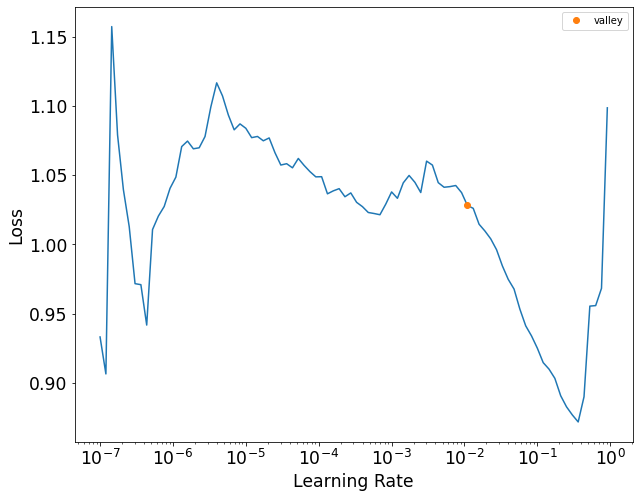

In [74]:
suggested_lr = learn.lr_find()
suggested_lr

### Training

In [75]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,0.968499,0.807930,00:00
1,0.695304,0.445684,00:00
2,0.530367,0.402602,00:00
3,0.450427,0.388584,00:00
4,0.409539,0.390250,00:00
5,0.388776,0.380822,00:00
6,0.374364,0.381169,00:00
7,0.363574,0.370051,00:00
8,0.352860,0.368671,00:00
9,0.348941,0.367079,00:00


In [76]:
# learn.val_preds, learn.val_targets #

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_training


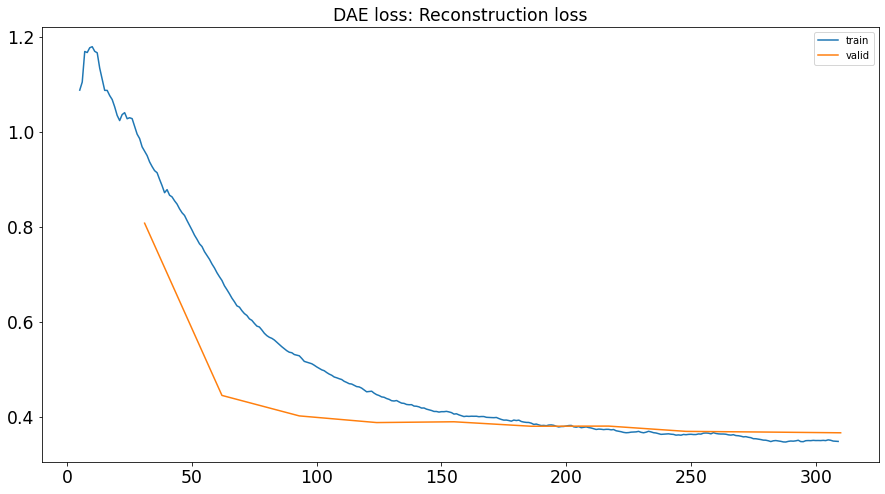

In [77]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('DAE loss: Reconstruction loss')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='dae_training',
                        folder=folder)

In [78]:
# L(zip(learn.recorder.iters, learn.recorder.values))


### Evaluation

In [79]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(4923, 4923)

MSE on transformed data is not too interesting for comparision between models if these use different standardizations

In [80]:
learn.loss_func(pred, target)  # MSE in transformed space not too interesting

TensorBase(0.3709)

In [81]:
# check target is in expected order
Y = dls.valid.targ

npt.assert_almost_equal(
    actual=target.numpy(),
    desired=Y.stack().to_numpy()
)

In [82]:
# import torch
# from fastai.tabular.core import TabularPandas

df_pred['intensity_pred_dae'] = ae.transform_preds(
    pred=pred, index=analysis.df_valid.stack().index, normalizer=tf_norm)
df_pred

intensity  \
Sample ID                           peptide                             
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK     31.358   
                                    DLEEDHACIPIK               29.764   
                                    FGYVDFESAEDLEK             29.106   
                                    IGDLQAFQGHGAGNLAGLK        29.867   
                                    SSEHINEGETAMLVCK           28.240   
...                                                               ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                 28.973   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                    31.110   
                                    KTEAPAAPAAQETK             31.690   
                                    QAQIEVVPSASALIIK           30.516   
                                    SSEHINEGETAMLVCK           29.820   

                                                            train_median  \
Sample ID                           peptide                                
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK        32.424   
                                    DLEEDHACIPIK                  30.036   
                                    FGYVDFESAEDLEK                30.022   
                                    IGDLQAFQGHGAGNLAGLK           30.666   
                                    SSEHINEGETAMLVCK              29.273   
...                                                                  ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                    28.941   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                       31.005   
                                    KTEAPAAPAAQETK                31.268   
                                    QAQIEVVPSASALIIK              30.019   
                                    SSEHINEGETAMLVCK              29.273   

                                                            train_average  \
Sample ID                           peptide                                 
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK         32.114   
                                    DLEEDHACIPIK                   30.528   
                                    FGYVDFESAEDLEK                 30.048   
                                    IGDLQAFQGHGAGNLAGLK            30.489   
                                    SSEHINEGETAMLVCK               28.994   
...                                                                   ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                     28.820   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                        30.981   
                                    KTEAPAAPAAQETK                 30.996   
                                    QAQIEVVPSASALIIK               29.921   
                                    SSEHINEGETAMLVCK               28.994   

                                                            replicates  \
Sample ID                           peptide                              
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK      31.311   
                                    DLEEDHACIPIK                29.605   
                                    FGYVDFESAEDLEK              29.449   
                                    IGDLQAFQGHGAGNLAGLK         29.785   
                                    SSEHINEGETAMLVCK            28.558   
...                                                                ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                  29.179   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                     30.844   
                                    KTEAPAAPAAQETK              31.645   
                                    QAQIEVVPSASALIIK            30.723   
                                    SSEHINEGETAMLVCK            29.760   

                                                            intensity_pred_collab  \
Sample ID                           peptide                            

### 2D plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [83]:
latent_space = []
for b in dls.valid:
    model_input = b[1]
    latent_space.append(model.encoder(model_input).detach().numpy())

df_dae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_dae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.672,-0.453
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,0.232,-0.232
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.856,-0.672
20181222_QE9_nLC9_QC_50CM_HeLa1,0.770,-0.689
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.439,-0.532


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_date


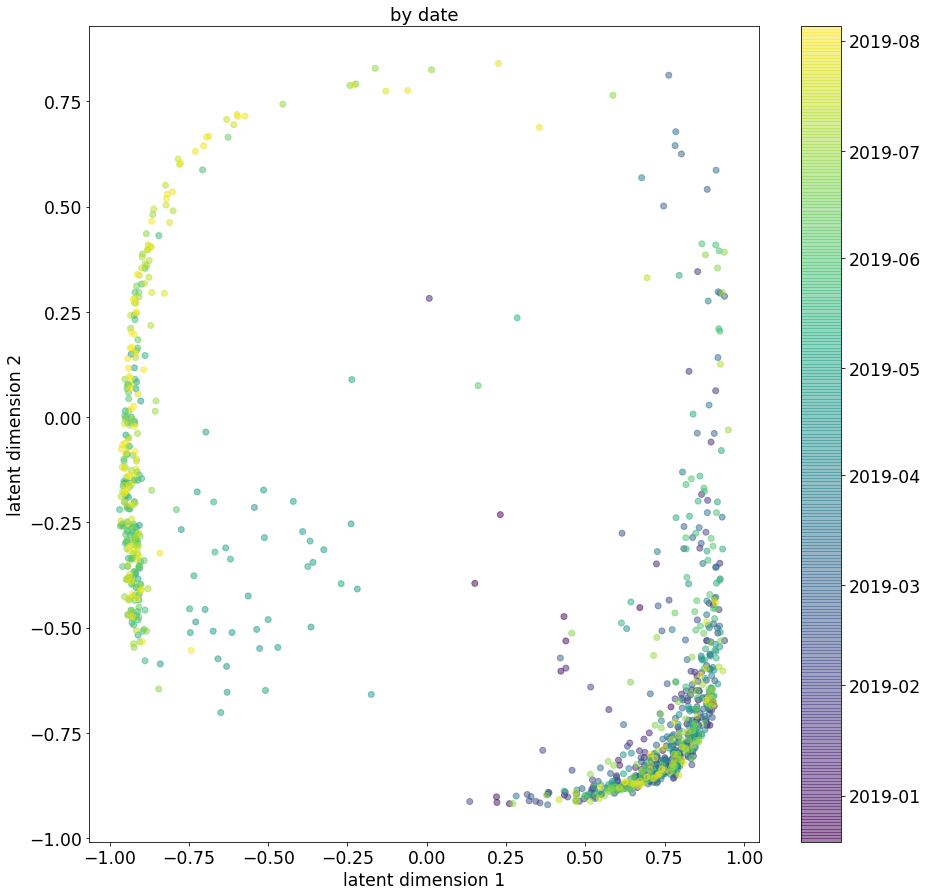

In [84]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_dae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_dae_latent.index])
vaep.io_images._savefig(fig, name='dae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_ms_instrument


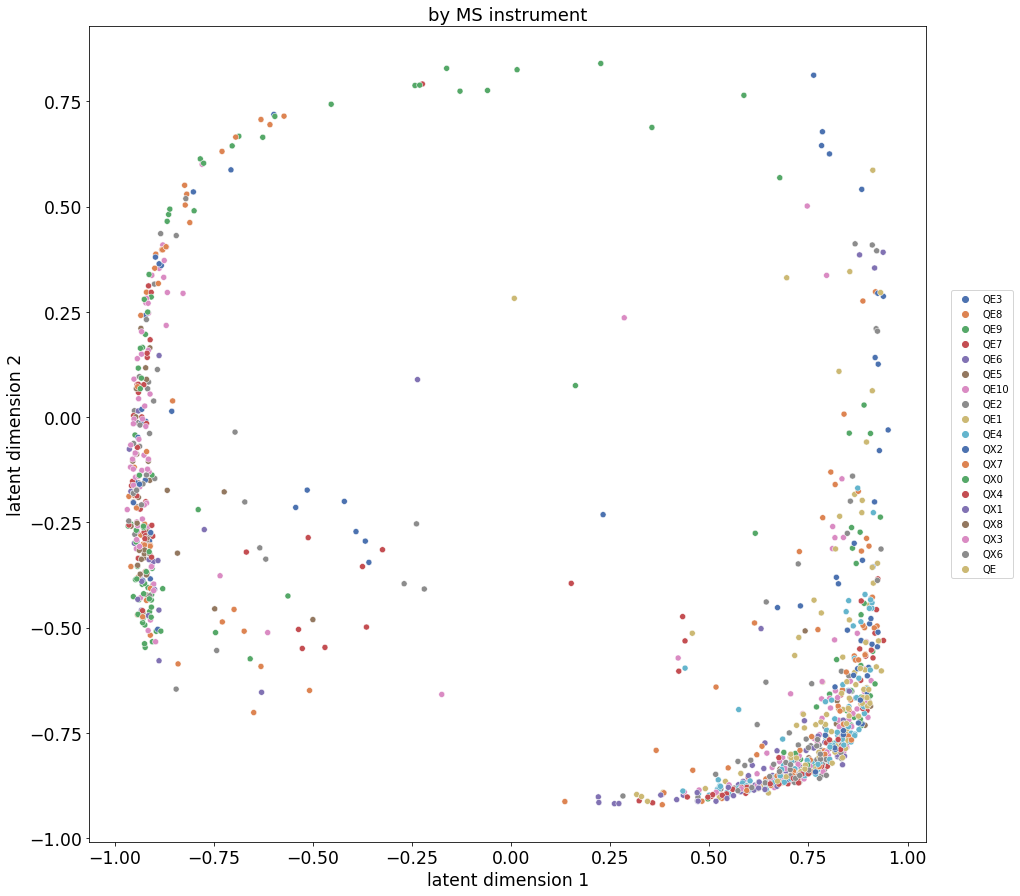

In [85]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_dae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_dae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'dae_latent_by_{meta_col}', folder=folder)

## Variational Autoencoder (VAE)

### Scikit Learn MinMaxScaler

- [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [86]:
from vaep.transform import MinMaxScaler

args_vae = {}
args_vae['SCALER'] = MinMaxScaler
# select initial data: transformed vs not log transformed
scaler = args_vae['SCALER']().fit(analysis.df_train)
scaler.transform(analysis.df_valid.iloc[:5])

peptide,AAVPSGASTGIYEALELRDNDK,AHSSMVGVNLPQK,AIVAIENPADVSVISSR,ALLFVPR,ALPAVQQNNLDEDLIRK,ALTSEIALLQSR,ASNGDAWVEAHGK,DHENIVIAK,DLEEDHACIPIK,DSYVGDEAQSK,...,SHTILLVQPTK,SLEDQVEMLR,SSEHINEGETAMLVCK,TATPQQAQEVHEK,TLTAVHDAILEDLVFPSEIVGK,TVLMNPNIASVQTNEVGLK,TVTAMDVVYALK,TYFSCTSAHTSTGDGTAMITR,VLSAPPHFHFGQTNR,YNILGTNTIMDK
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534,NaN,...,NaN,NaN,0.620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,0.651,NaN,NaN,0.595,NaN,0.220,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.615
20181222_QE9_nLC9_QC_50CM_HeLa1,0.751,NaN,NaN,0.637,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### DataLoaders

- follow instructions for using plain PyTorch Datasets, see [tutorial](https://docs.fast.ai/tutorial.siamese.html#Preparing-the-data)


In [87]:
assert all(analysis.df_train.columns == analysis.df_valid.columns)
if not all(analysis.df.columns == analysis.df_train.columns):
    print("analysis.df columns are not the same as analysis.df_train")
    # ToDo: DataLoading has to be cleaned up
    # analysis.df = analysis.df_train.fillna(analysis.df_valid)

analysis.df columns are not the same as analysis.df_train


In [88]:
from vaep.io.datasets import PeptideDatasetInMemory

FILL_NA = 0.0

train_ds = PeptideDatasetInMemory(data=scaler.transform(
    analysis.df_train).to_numpy(dtype=None), fill_na=FILL_NA)
valid_ds = PeptideDatasetInMemory(data=scaler.transform(analysis.df_train.fillna(analysis.df_valid)).to_numpy(dtype=None),
                                  mask=analysis.df_valid.notna().to_numpy(), fill_na=FILL_NA)

assert (train_ds.peptides == valid_ds.peptides).all()

In [89]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, n_inp=2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


### Model

In [90]:
from torch.nn import Sigmoid

M = analysis.df_train.shape[-1]
model = ae.VAE(n_features=M, n_neurons=int(
    M/2), last_encoder_activation=None, last_decoder_activation=Sigmoid, dim_latent=latent_dim)

### Learner

In [91]:
learn = Learner(dls=dls,
                model=model,
                loss_func=ae.loss_fct_vae,
                cbs=ae.ModelAdapterVAE())

learn.show_training_loop()
learn.summary()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapterVAE]
         - after_pred     : [ModelAdapterVAE]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback

VAE (Input shape: 64 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     64 x 50             
Linear                                    1300       True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     64 x 4              
Linear                                    104        True      
______________________________________________________________

### Training

SuggestedLRs(valley=0.00363078061491251)

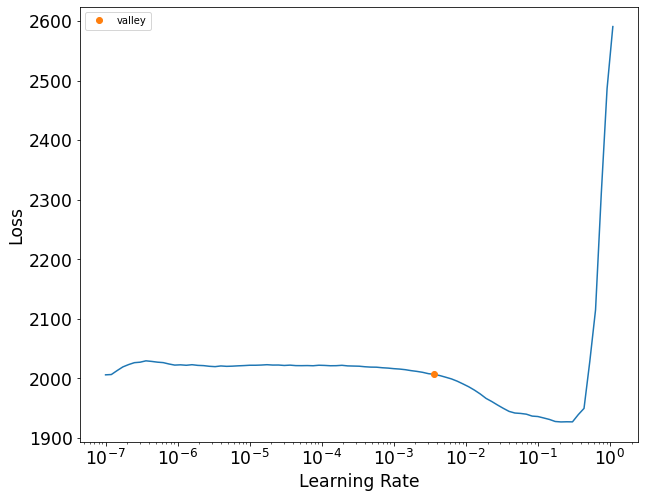

In [92]:
suggested_lr = learn.lr_find()
suggested_lr

In [93]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,2008.388062,217.378143,00:00
1,1963.695312,207.495682,00:00
2,1892.144043,197.567886,00:00
3,1833.081299,192.132599,00:00
4,1795.163574,189.988235,00:00
5,1769.522827,189.317657,00:00
6,1752.220337,189.198853,00:00
7,1740.677002,189.216080,00:00
8,1731.904785,189.102783,00:00
9,1726.687500,189.116043,00:00


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_training


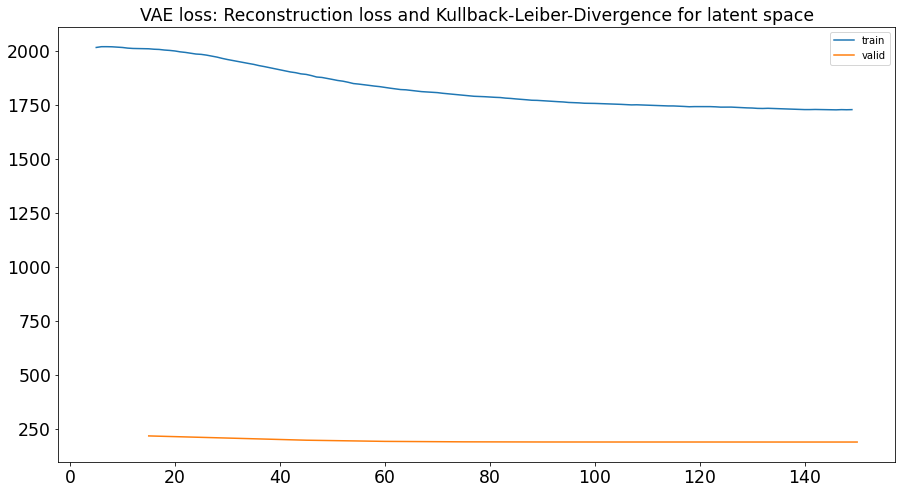

In [94]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('VAE loss: Reconstruction loss and Kullback-Leiber-Divergence for latent space')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='vae_training',
                        folder=folder)

### Evaluation

In [95]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(3, 4923)

In [96]:
len(pred[0])

4923

In [97]:
learn.loss_func(pred, target)

tensor(2985.9663)

In [98]:
_pred = pd.Series(pred[0], index=analysis.df_valid.stack().index).unstack()
_pred = scaler.inverse_transform(_pred).stack()

df_pred['intensity_pred_vae'] = _pred
df_pred

intensity  \
Sample ID                           peptide                             
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK     31.358   
                                    DLEEDHACIPIK               29.764   
                                    FGYVDFESAEDLEK             29.106   
                                    IGDLQAFQGHGAGNLAGLK        29.867   
                                    SSEHINEGETAMLVCK           28.240   
...                                                               ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                 28.973   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                    31.110   
                                    KTEAPAAPAAQETK             31.690   
                                    QAQIEVVPSASALIIK           30.516   
                                    SSEHINEGETAMLVCK           29.820   

                                                            train_median  \
Sample ID                           peptide                                
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK        32.424   
                                    DLEEDHACIPIK                  30.036   
                                    FGYVDFESAEDLEK                30.022   
                                    IGDLQAFQGHGAGNLAGLK           30.666   
                                    SSEHINEGETAMLVCK              29.273   
...                                                                  ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                    28.941   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                       31.005   
                                    KTEAPAAPAAQETK                31.268   
                                    QAQIEVVPSASALIIK              30.019   
                                    SSEHINEGETAMLVCK              29.273   

                                                            train_average  \
Sample ID                           peptide                                 
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK         32.114   
                                    DLEEDHACIPIK                   30.528   
                                    FGYVDFESAEDLEK                 30.048   
                                    IGDLQAFQGHGAGNLAGLK            30.489   
                                    SSEHINEGETAMLVCK               28.994   
...                                                                   ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                     28.820   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                        30.981   
                                    KTEAPAAPAAQETK                 30.996   
                                    QAQIEVVPSASALIIK               29.921   
                                    SSEHINEGETAMLVCK               28.994   

                                                            replicates  \
Sample ID                           peptide                              
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAVPSGASTGIYEALELRDNDK      31.311   
                                    DLEEDHACIPIK                29.605   
                                    FGYVDFESAEDLEK              29.449   
                                    IGDLQAFQGHGAGNLAGLK         29.785   
                                    SSEHINEGETAMLVCK            28.558   
...                                                                ...   
20190805_QE1_nLC2_AB_MNT_HELA_03    SLEDQVEMLR                  29.179   
20190805_QE1_nLC2_AB_MNT_HELA_04    ALLFVPR                     30.844   
                                    KTEAPAAPAAQETK              31.645   
                                    QAQIEVVPSASALIIK            30.723   
                                    SSEHINEGETAMLVCK            29.760   

                                                            intensity_pred_collab  \
Sample ID                           peptide                            

### Add plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [99]:
latent_space = []
for b in dls.valid:
    model_input = b[0]
    b_mu, b_std = model.get_mu_and_logvar(model_input, detach=True)
    latent_space.append(b_mu)


df_vae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_vae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.041,0.082
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.085,0.096
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.057,0.020
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.071,0.002
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.079,0.087


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_date


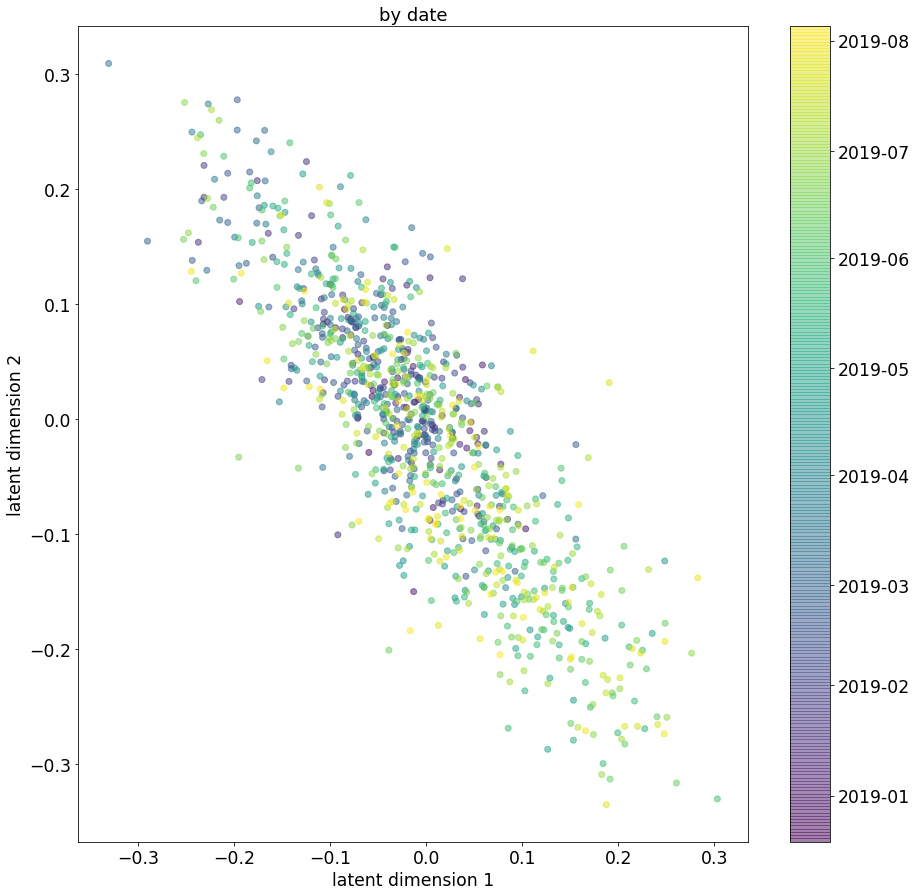

In [100]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_vae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_vae_latent.index])
vaep.io_images._savefig(fig, name='vae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_ms_instrument


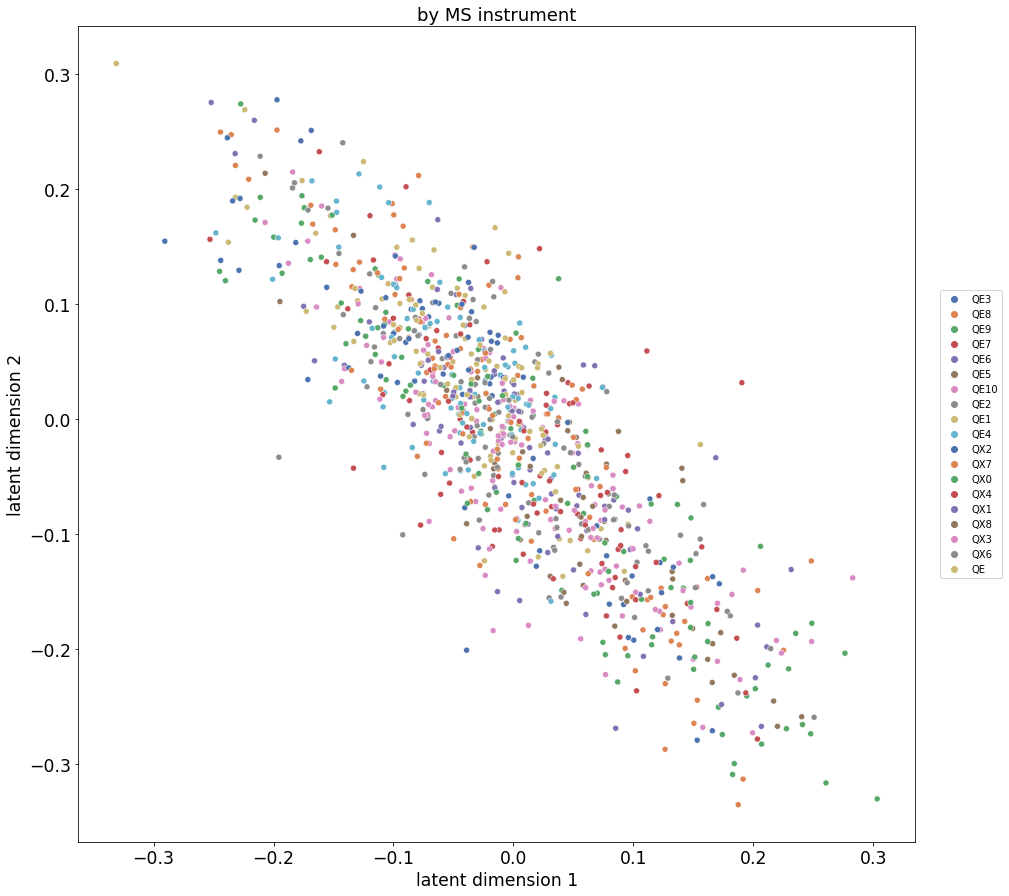

In [101]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_vae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_vae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'vae_latent_by_{meta_col}', folder=folder)

## Compare the 3 models

- replicates: replace NAs with neighbouring ("close") values
- train average, median: Replace NA with average or median from training data

In [102]:
import sklearn.metrics as sklm
pred_columns = df_pred.columns[1:]
scoring = [('MSE', sklm.mean_squared_error),
           ('MAE', sklm.mean_absolute_error)]

y_true = df_pred['intensity']

metrics = {}
for col in pred_columns:
    _y_pred = df_pred[col].dropna()
    if len(df_pred[col]) > len(_y_pred):
        logger.info(
            f"Drop indices for {col}: {[(idx[0], idx[1]) for idx in df_pred[col].index.difference(_y_pred.index)]}")

    metrics[col] = dict(
        [(k, f(y_true=y_true.loc[_y_pred.index], y_pred=_y_pred))
         for k, f in scoring]
    )

metrics = pd.DataFrame(metrics)
metrics.to_csv(folder / f'exp_02_metrics.csv',
               float_format='{:.3f}'.format)
metrics.sort_values(by=[k for k, f in scoring], axis=1)

vaep - INFO     Drop indices for replicates: [('20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_03', 'IIAPPERK'), ('20190111_QE8_nLC1_ASD_QC_HeLa_01', 'SSEHINEGETAMLVCK'), ('20190115_QE2_NLC10_TW_QC_MNT_HeLa_01', 'IWHHTFYNELR'), ('20190118_QE1_nLC2_ANHO_QC_MNT_HELA_03', 'TATPQQAQEVHEK'), ('20190122_QE6_nLC6_SIS_QC_MNT_HeLa_01', 'FGYVDFESAEDLEK'), ('20190126_QE6_nLC6_SIS_QC_MNT_HeLa_05', 'KTEAPAAPAAQETK'), ('20190204_QE9_nLC9_NHS_MNT_HELA_45cm_Newcolm_01', 'MALIGLGVSHPVLK'), ('20190219_QE10_nLC14_FaCo_QC_HeLa_50cm_20190221093339', 'VLSAPPHFHFGQTNR'), ('20190219_QE2_NLC1_GP_QC_MNT_HELA_01', 'VLSAPPHFHFGQTNR'), ('20190225_QE10_PhGe_Evosep_88min_HeLa_6', 'DHENIVIAK'), ('20190225_QE10_PhGe_Evosep_88min_HeLa_8', 'EQISDIDDAVR'), ('20190226_QE10_PhGe_Evosep_88min-30cmCol-HeLa_14_30', 'EAAENSLVAYK'), ('20190226_QE10_PhGe_Evosep_88min-30cmCol-HeLa_16_25', 'VLSAPPHFHFGQTNR'), ('20190226_QE10_PhGe_Evosep_88min-30cmCol-HeLa_16_27', 'IIAPPERK'), ('20190226_QE10_PhGe_Evosep_88min-30cmCol-HeLa_18_30', 'IIAPPERK'),

,intensity_pred_collab,intensity_pred_dae,replicates,intensity_pred_vae,train_average,train_median
MSE,0.598,0.672,1.634,1.925,1.931,1.985
MAE,0.474,0.504,0.871,1.004,1.016,0.993


Save final prediction values of validation data for later comparison.

In [103]:
df_pred.to_csv(folder /
               f"{config.FOLDER_DATA}_valid_pred.csv")

## PCA plot for imputed and denoised data

two setups:
 - impute missing values
 - additinally change observed values